## Прогноз количества заказов такси

Агрегатор такси в Чикаго хочет прогнозировать количество заказов в каждом районе. 
Это необходимо, чтобы в моменты пиковой нагрузки привлекать больше водителей, а во время спада оотправлять их в другие места. 
Для обучения модели машинного обучения предоставлены данные о 10 млн заказов такси за 2022 и 2023 год.
Информацию собирает регулирующий орган. Из соображений конфиденциальности, идентификатор такси соответствует заданному номеру медальона такси, переписные участки в некоторых случаях скрыты, а время округляется до ближайших 15 минут.

Метриками качества приняты МАЕ и MAPE.

По условиям проекта, необходимо развернуть локальные контейнеры через Docker и произвести большую часть работ в PySpark.

### Импортируем библиотеки, загрузим данные, посмотрим их состав

In [ ]:
pip install prophet

In [2]:
pip install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tracemalloc

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [4]:
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config('spark.local.dir', 'spark_tmp/') \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

spark = SparkSession.builder.appName("Introduction to Spark").getOrCreate()

In [5]:
spark

О поездках на такси сообщается городу Чикаго в его роли регулирующего органа. Чтобы защитить конфиденциальность, но обеспечить совокупный анализ, идентификатор такси соответствует любому заданному номеру медальона такси, но не показывает номер, переписные участки в некоторых случаях скрыты, а время округляется до ближайших 15 минут.

In [6]:
dfsp22 = spark.read.csv("Taxi_Trips_-_2022.csv", header = True, inferSchema = True)
dfsp22.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

In [7]:
dfsp23 = spark.read.csv("Taxi_Trips_-_2023.csv", header = True, inferSchema = True)
lim23 = '2023-07-31 23:00'
dfsp23 = dfsp23.filter(F.to_timestamp(F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a')<lim23)
dfsp23.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

    В последнем часе наблюдений 2023-08-01 00:00 поездок мало, заказчик просил его не учитывать.

    в качестве тестового берем 2023-07-31 23:00, поэтому сразу отрежем все наблюдения по нему.

In [8]:
print(type(dfsp22))
dfsp22.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: doubl

# Объединим данные, обработаем дубликаты, пропуски, выбросы

In [9]:
if dfsp22.columns != dfsp23.columns:
    print('разная структура')
else:
    dfsp = dfsp22.union(dfsp23).cache()
    print('Данные за 2022 и 2023 годы успешно объединены')


Данные за 2022 и 2023 годы успешно объединены


In [10]:
#проверим на дубликаты
df = dfsp.dropDuplicates(dfsp.columns)
if df.count() == dfsp.count():
    print('как и заявлено в описании данных, полных дубликатов нет')

else: 
    print('Полных дубликатов', dfsp.dropDuplicates(dfsp.columns))


как и заявлено в описании данных, полных дубликатов нет


In [11]:
#переименуем колонки в df
for col in dfsp.columns:
    dfsp = dfsp.withColumnRenamed(col, col.lower().replace(' ', '_'))
print(dfsp.columns)

['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid__location']


In [12]:
tracemalloc.start()
def mem_use():
    mem_size, mem_peak = tracemalloc.get_traced_memory()
    print(f'Количество используемой памяти {mem_size:_} байт, '
          f'пиковое {mem_peak:_} байт')

mem_use()

Количество используемой памяти 1_536 байт, пиковое 14_432 байт


In [13]:
dfsp.show(5, truncate = 30)
dfsp.count()

+------------------------------+------------------------------+----------------------+----------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------------+-------------------------+--------------------------+------------------------------+
|                       trip_id|                       taxi_id|  trip_start_timestamp|    trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area| fare|tips|tolls|extras|trip_total|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|      pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|    dropoff_centroid__location|
+------------------------------+------------------------------+----------------------+----

10165684

In [14]:
dfsp.select('pickup_community_area').distinct().sort(dfsp.pickup_community_area.asc()).show(80)
dfsp.select('pickup_community_area').distinct().count()

+---------------------+
|pickup_community_area|
+---------------------+
|                 null|
|                    1|
|                    2|
|                    3|
|                    4|
|                    5|
|                    6|
|                    7|
|                    8|
|                    9|
|                   10|
|                   11|
|                   12|
|                   13|
|                   14|
|                   15|
|                   16|
|                   17|
|                   18|
|                   19|
|                   20|
|                   21|
|                   22|
|                   23|
|                   24|
|                   25|
|                   26|
|                   27|
|                   28|
|                   29|
|                   30|
|                   31|
|                   32|
|                   33|
|                   34|
|                   35|
|                   36|
|                   37|
|               

78

In [15]:
# Посчитаем пропуски
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df
count_missings(dfsp)

,count
pickup_census_tract,5891728
dropoff_census_tract,5872822
dropoff_community_area,998271
dropoff_centroid__location,939636
dropoff_centroid_longitude,939636
dropoff_centroid_latitude,939636
pickup_community_area,681597
pickup_centroid_location,677907
pickup_centroid_longitude,677907
pickup_centroid_latitude,677907


    По задаче нам необходимо предсказть количество заказов и необходимое количество машин в Community. Если в строке нет данных о районе, 
    отсутствует определяющий признак. Такие строки мы не сможем использовать.

## Посмотрим цензусы пропусков в Коммьюнити

In [16]:
empty_census = dfsp.filter('pickup_community_area is NULL and pickup_census_tract is not NULL').select(
    'pickup_census_tract', 'pickup_community_area').distinct()

In [17]:
empty_census = empty_census.select('pickup_census_tract')
empty_census.show()

+-------------------+
|pickup_census_tract|
+-------------------+
|        17031827901|
|        17031802900|
|        17031802801|
|        17031827801|
|        17031810301|
|        17031807600|
|        17031808002|
|        17031807300|
|        17031770700|
|        17031770800|
|        17031806202|
|        17031806104|
|        17031811600|
|        17031802402|
|        17031804603|
|        17031809400|
|        17031806004|
|        17031816200|
|        17031804609|
|        17031806600|
+-------------------+
only showing top 20 rows



In [18]:
dfsp.filter('pickup_community_area is NULL and pickup_census_tract is not NULL').select(
    'pickup_census_tract', 'pickup_community_area').count()

4991

### Промежуточный вывод:
    Для обучения предотоставлены данные о 10 млн заказов. в данных есть следующие артефакты:
    1. данные о времени представлены в формате строк.
    2. пропуски, в том числе 681620 в столбцах с районом
        - у некоторых пропусков в районах есть Цензус. 
        По карте эти цензусы находятся в разных пригородах, пока обозначим их как 0 Community.
        Можно в дальнейшем заполнить из ближайшими соседями или вручную.
        https://www.chicagocityscape.com/index.php - здесь можно найти расположение цензусов вне городской черты
        https://www.chicagocityscape.com/maps/index.php?place=censustract-17031801500
        - остальные пропуски в районах придется удалить, потому что отсутствует определяющий признак

In [19]:
dfsp = dfsp.withColumn(
    'pickup_community_area',
    #when((F.col("pickup_census_tract") == '17031770700'), 76)\
    when((dfsp.pickup_census_tract.isNotNull() & dfsp.pickup_community_area.isNull()), 0) \
  #  F.when((F.col("pickup_census_tract") is not NULL'), 0)\
    #.when((F.col("ts") == 'L') & (F.col('days_r') >=0) & (F.col('days_r') <= 7), 1)\
    .otherwise(dfsp.pickup_community_area))

In [20]:
dfsp.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+
|             trip_id|             taxi_id|trip_start_timestamp|  trip_end_timestamp|trip_seconds|trip_miles|pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area| fare|tips|tolls|extras|trip_total|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|pickup_centroid_location|dropoff_centroid_latitude|dropoff_centroid_longitude|dropoff_centroid__location|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+--------

In [21]:
dfsp.filter('pickup_community_area is NULL and pickup_census_tract is not NULL').select(
    'pickup_census_tract', 'pickup_community_area').count()

0

In [22]:
dfsp.filter('pickup_community_area is NULL').count()

676606

In [23]:
dfsp_filtered = dfsp.na.drop(how = "all", subset = ["pickup_community_area", 'pickup_census_tract'])
count_missings(dfsp_filtered)

,count
dropoff_census_tract,5376331
pickup_census_tract,5215122
dropoff_community_area,670458
dropoff_centroid__location,618879
dropoff_centroid_longitude,618879
dropoff_centroid_latitude,618879
fare,8138
trip_total,8138
extras,8138
tolls,8138


In [24]:
dfsp_filtered.select('pickup_community_area').distinct().sort(dfsp.pickup_community_area.asc()).show(80)

+---------------------+
|pickup_community_area|
+---------------------+
|                    0|
|                    1|
|                    2|
|                    3|
|                    4|
|                    5|
|                    6|
|                    7|
|                    8|
|                    9|
|                   10|
|                   11|
|                   12|
|                   13|
|                   14|
|                   15|
|                   16|
|                   17|
|                   18|
|                   19|
|                   20|
|                   21|
|                   22|
|                   23|
|                   24|
|                   25|
|                   26|
|                   27|
|                   28|
|                   29|
|                   30|
|                   31|
|                   32|
|                   33|
|                   34|
|                   35|
|                   36|
|                   37|
|               

In [25]:
dfsp_filtered.count()

9489078

    Устранили пропуски в районах - осталось 9489526 - потеряли около 7%

## Проверим пропуски в колонках по времени, расстоянию и деньгам

In [26]:
dfsp_filtered.filter('trip_seconds is NULL').select(
    'trip_start_timestamp', 'trip_end_timestamp', 
    'trip_miles', 'trip_seconds', 'trip_total', 'fare').show(10, False)

+----------------------+----------------------+----------+------------+----------+-----+
|trip_start_timestamp  |trip_end_timestamp    |trip_miles|trip_seconds|trip_total|fare |
+----------------------+----------------------+----------+------------+----------+-----+
|01/01/2022 02:45:00 AM|01/03/2022 03:45:00 PM|45.08     |null        |107.0     |106.0|
|01/01/2022 05:30:00 AM|01/02/2022 10:30:00 AM|8.24      |null        |22.5      |22.5 |
|01/02/2022 12:00:00 AM|null                  |0.0       |null        |0.0       |0.0  |
|01/02/2022 10:45:00 PM|01/04/2022 09:00:00 AM|1.43      |null        |7.75      |7.75 |
|01/03/2022 03:30:00 PM|null                  |0.0       |null        |0.0       |0.0  |
|01/03/2022 04:15:00 PM|01/05/2022 12:45:00 PM|0.0       |null        |3.25      |3.25 |
|01/04/2022 12:15:00 PM|01/05/2022 11:30:00 PM|0.15      |null        |3.5       |3.5  |
|01/05/2022 07:30:00 PM|01/11/2022 04:45:00 PM|9.19      |null        |28.5      |24.5 |
|01/06/2022 01:15:00 

In [27]:
dfsp_filtered.filter('trip_miles is NULL').select(
        'trip_end_timestamp', 'trip_end_timestamp', 
        'trip_miles', 'trip_seconds', 'trip_total', 'fare').show(10, False)

+----------------------+----------------------+----------+------------+----------+-----+
|trip_end_timestamp    |trip_end_timestamp    |trip_miles|trip_seconds|trip_total|fare |
+----------------------+----------------------+----------+------------+----------+-----+
|01/01/2022 01:15:00 AM|01/01/2022 01:15:00 AM|null      |1022        |36.52     |29.83|
|01/01/2022 08:15:00 PM|01/01/2022 08:15:00 PM|null      |379         |23.68     |20.26|
|01/02/2022 12:45:00 PM|01/02/2022 12:45:00 PM|null      |2           |12.93     |10.53|
|01/03/2022 07:00:00 AM|01/03/2022 07:00:00 AM|null      |15          |11.5      |9.36 |
|01/03/2022 01:15:00 PM|01/03/2022 01:15:00 PM|null      |978         |19.4      |15.82|
|01/07/2022 06:00:00 AM|01/07/2022 06:00:00 AM|null      |50          |12.57     |9.36 |
|01/07/2022 01:15:00 PM|01/07/2022 01:15:00 PM|null      |215         |11.5      |9.36 |
|01/08/2022 03:30:00 PM|01/08/2022 03:30:00 PM|null      |1973        |37.02     |30.24|
|01/09/2022 01:15:00 

In [28]:
dfsp_filtered.filter('trip_total is NULL').select(
    'trip_end_timestamp', 'trip_end_timestamp', 
    'trip_miles', 'trip_seconds', 'trip_total', 'fare').show(10, False)

+----------------------+----------------------+----------+------------+----------+----+
|trip_end_timestamp    |trip_end_timestamp    |trip_miles|trip_seconds|trip_total|fare|
+----------------------+----------------------+----------+------------+----------+----+
|01/02/2022 06:45:00 PM|01/02/2022 06:45:00 PM|1.38      |306         |null      |null|
|01/03/2022 01:15:00 AM|01/03/2022 01:15:00 AM|0.0       |40          |null      |null|
|01/03/2022 02:15:00 PM|01/03/2022 02:15:00 PM|7.15      |3254        |null      |null|
|01/04/2022 05:30:00 PM|01/04/2022 05:30:00 PM|4.33      |1281        |null      |null|
|01/04/2022 08:00:00 PM|01/04/2022 08:00:00 PM|0.06      |3           |null      |null|
|01/05/2022 04:15:00 AM|01/05/2022 04:15:00 AM|0.63      |70          |null      |null|
|01/05/2022 01:15:00 PM|01/05/2022 01:15:00 PM|0.31      |103         |null      |null|
|01/05/2022 05:30:00 PM|01/05/2022 05:30:00 PM|0.09      |85          |null      |null|
|01/06/2022 12:00:00 PM|01/06/20

    Пропуски по длительности поездки идут вразнобой, 
    метки времени начала и окончания поездки отсутствуют или совпадают. 
    Видимо, был либо сбой системы подсчета, либо поездка не была совершена. 
    Таких данных немного, пока удалим их, чтобы не искажать данные заполнением.
    По деньгам и расстоянию, скорее всего подсчет проводится автоматически и отсутствие данных означает сбои. 
    Их тоже пока удалим. это в сумме около 8 тысяч строк - 0,08%.

In [29]:
mem_use()

Количество используемой памяти 7_642_908 байт, пиковое 7_702_316 байт


In [30]:
dfsp_filtered = dfsp_filtered.na.drop(how = "any", subset = ["trip_seconds", 'trip_miles', 'trip_total'])
count_missings(dfsp_filtered)

,count
dropoff_census_tract,5371782
pickup_census_tract,5210863
dropoff_community_area,669464
dropoff_centroid__location,617971
dropoff_centroid_longitude,617971
dropoff_centroid_latitude,617971
pickup_centroid_location,1295
pickup_centroid_longitude,1295
pickup_centroid_latitude,1295
extras,0


In [31]:
dfsp.unpersist(blocking = True)

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: string, trip_end_timestamp: string, trip_seconds: int, trip_miles: double, pickup_census_tract: bigint, dropoff_census_tract: bigint, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, pickup_centroid_latitude: double, pickup_centroid_longitude: double, pickup_centroid_location: string, dropoff_centroid_latitude: double, dropoff_centroid_longitude: double, dropoff_centroid__location: string]

In [32]:
mem_use()

Количество используемой памяти 7_688_988 байт, пиковое 7_812_279 байт


## Посмотрим нулевые значения

In [33]:
dfsp_filtered.filter('trip_seconds == 0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').count()

207086

In [34]:
dfsp_filtered.filter('trip_miles ==0.0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').count()

1111744

In [35]:
dfsp_filtered.filter('trip_total ==0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').count()

7782

In [36]:
dfsp_filtered.filter('trip_seconds == 0').select(
    'trip_end_timestamp','trip_end_timestamp', 
    'trip_total', 'fare', 'trip_miles', 'trip_seconds').groupby('trip_seconds').mean().show()

+------------+------------------+-----------------+-------------------+-----------------+
|trip_seconds|   avg(trip_total)|        avg(fare)|    avg(trip_miles)|avg(trip_seconds)|
+------------+------------------+-----------------+-------------------+-----------------+
|           0|13.124867349796725|8.236687270023085|0.28704518895531284|              0.0|
+------------+------------------+-----------------+-------------------+-----------------+



In [37]:
dfsp_filtered.filter('trip_total == 0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').groupby('trip_total').mean().show()

+----------+------------------+-----------------+---------------+---------+
|trip_total|   avg(trip_miles)|avg(trip_seconds)|avg(trip_total)|avg(fare)|
+----------+------------------+-----------------+---------------+---------+
|       0.0|2.0700539707016192|744.3969416602416|            0.0|      0.0|
+----------+------------------+-----------------+---------------+---------+



In [38]:
dfsp_filtered.filter('trip_miles == 0').select(
    'trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles', 'trip_seconds', 'trip_total', 'fare').groupby('trip_miles').mean().show()

+----------+---------------+-----------------+-----------------+------------------+
|trip_miles|avg(trip_miles)|avg(trip_seconds)|  avg(trip_total)|         avg(fare)|
+----------+---------------+-----------------+-----------------+------------------+
|       0.0|            0.0|579.7355461329227|19.35912257677995|15.133533754173664|
+----------+---------------+-----------------+-----------------+------------------+



    Проверка 0 так же проказала большое количество утерянных данных. 
    В сумме получается около 1,3 млн строк с 0 в одной из колонок. при этом остальные данные присутствуют.
    Такие данные можно попробовать использовать в обучении.
    На этом этапе выявим их, но не будем менять. 
    В случае потери качества при обучении моделей, обработаем эти 0.

    промежуточный датасэт - dfsp_filtered

## Обработаем выбросы

In [39]:
dfpd_for_graphs = dfsp_filtered.orderBy(rand()).limit(10**5).select('pickup_centroid_latitude', 'pickup_centroid_longitude',
                                  'trip_total', 'trip_seconds', 'trip_miles', 'fare'
                                    ).toPandas()

count    100000.000000
mean       1186.351610
std        1765.861168
min           0.000000
25%         460.000000
50%         854.000000
75%        1620.000000
max       81737.000000
Name: trip_seconds, dtype: float64
4260.0
4.0


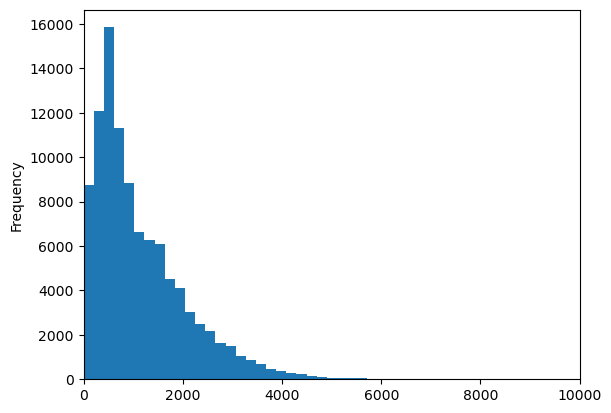

In [40]:
print(dfpd_for_graphs['trip_seconds'].describe())
print(dfpd_for_graphs['trip_seconds'].quantile(0.99))
print(dfpd_for_graphs['trip_seconds'].quantile(0.025))

dfpd_for_graphs['trip_seconds'].plot.hist(bins=400)#, range =(0.0, trip_seconds['trip_seconds'].quantile(0.975)))
plt.xlim(0.0, 10000)#trip_seconds.quantile(0.99))
plt.show()

In [41]:
trip_seconds_quant = dfsp_filtered.approxQuantile("trip_seconds", [0.025, 0.99], 0.005)
print(trip_seconds_quant)

[4.0, 4080.0]


count    100000.000000
mean          6.001367
std           7.354992
min           0.000000
25%           0.880000
50%           2.510000
75%          10.700000
max         601.400000
Name: trip_miles, dtype: float64
25.2
0.0


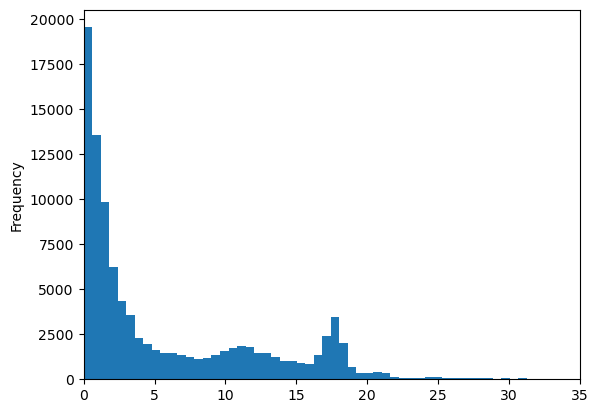

In [42]:
print(dfpd_for_graphs['trip_miles'].describe())
print(dfpd_for_graphs['trip_miles'].quantile(0.99))
print(dfpd_for_graphs['trip_miles'].quantile(0.1))

dfpd_for_graphs['trip_miles'].plot.hist(bins=1000)
plt.xlim(0.0, 35)#trip_miles['trip_miles'].quantile(0.99))

plt.show()

In [43]:
trip_miles_quant = dfsp_filtered.approxQuantile("trip_miles", [0.025, 0.99], 0.005)
print(trip_miles_quant)

[0.0, 23.94]


count    100000.000000
mean         25.955690
std          43.778698
min           0.000000
25%           9.947500
50%          16.390000
75%          37.250000
max        6080.650000
Name: trip_total, dtype: float64
92.50079999999959
6.5


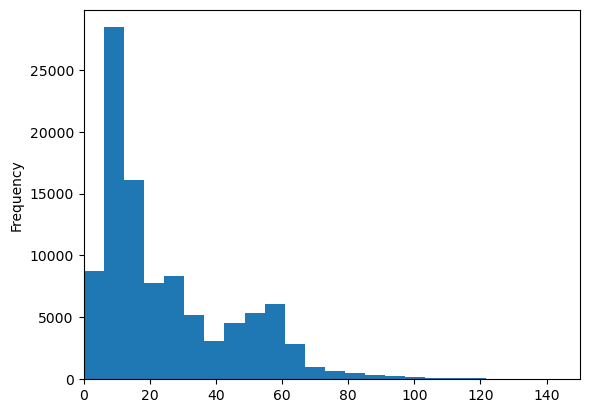

In [44]:
print(dfpd_for_graphs['trip_total'].describe())
print(dfpd_for_graphs['trip_total'].quantile(0.99))
print(dfpd_for_graphs['trip_total'].quantile(0.1))

dfpd_for_graphs['trip_total'].plot.hist(bins=1000)
plt.xlim(0.0, 150)#trip_total['trip_total'].quantile(0.99))
plt.show()

In [45]:
trip_total_quant = dfsp_filtered.approxQuantile("trip_total", [0.025, 0.994], 0.005)
print(trip_total_quant)

[3.25, 96.4]


    Квантили не выглядят выбросами. Поездка может длиться 4000 секунд, 23 мили и стоить 100 долларов.
    Похоже, что квантили, даже 99% не отражают выбросы.
    Лучше отсечем выбросы не по квантилям, а по абсолютным значениям:
        5500 секунд(2 часа)
        50 миль - город по диагонали приблизительно 28,5 миль
        300 $   

In [46]:
dfsp_filtered.filter((dfsp_filtered.trip_seconds > 5500)  #trip_seconds_quant[1]) \
                    |(dfsp_filtered.trip_miles > 50)  #trip_miles_quant[1]) \
                     |(dfsp_filtered.trip_total > 300)  #trip_total_quant[1])
                    ).count()

35636

In [47]:
dfsp_contracted = dfsp_filtered.filter((dfsp_filtered.trip_seconds <= 5500)  #trip_seconds_quant[1]) \
                    |(dfsp_filtered.trip_miles <= 50)  #trip_miles_quant[1]) \
                     |(dfsp_filtered.trip_total <= 300)  #trip_total_quant[1])
                    )
dfsp_contracted.count()

9478824

In [48]:
mem_use()

Количество используемой памяти 35_154_934 байт, пиковое 69_688_763 байт


    После удаления того, что принято за выбросы, осталось 9,48 млн данных - около 90%.
    Часть данных можно сохранить проведя более детальный разбор выбросов.

## Обработаем данные о времени: изменим формат на Timestamp и округлим до часа

In [49]:
#Timestamp String to DateType
dfsp_contracted = dfsp_contracted \
    .withColumn("trip_end_timestamp", F.date_trunc("hour", to_timestamp("trip_end_timestamp", "MM/dd/yyyy hh:mm:ss a"))) \
            .withColumn("trip_start_timestamp", F.date_trunc("hour", to_timestamp("trip_start_timestamp", "MM/dd/yyyy hh:mm:ss a")))
dfsp_contracted.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- pickup_centroid_location: string (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_cen

    максимальная метка времени взятия пассажира 2023-08-01 00:00:00

In [50]:
dfsp_timed = dfsp_contracted.withColumn("trip_start_timestamp", F.date_trunc("hour", dfsp_contracted.trip_start_timestamp)) \
                   .withColumn("trip_end_timestamp", F.date_trunc("hour", dfsp_contracted.trip_end_timestamp))
#dfsp_timed = dfsp_timed.withColumn("trip_end_timestamp", F.date_trunc("hour", dfsp_timed.trip_end_timestamp))
dfsp_timed.select('trip_start_timestamp', 'trip_end_timestamp').show(5)
dfsp_timed.sort(dfsp_timed.trip_start_timestamp.desc()).select('trip_start_timestamp', 'trip_end_timestamp').show(5)
dfsp_timed.filter((dfsp_timed["trip_start_timestamp"] > '2023-06-01 00:00:00') &
            (dfsp_timed["trip_start_timestamp"] < '2023-07-01 00:00:00')).select(
                    'trip_id', 'trip_start_timestamp', 'trip_end_timestamp').show(10, False)

+--------------------+-------------------+
|trip_start_timestamp| trip_end_timestamp|
+--------------------+-------------------+
| 2022-01-01 00:00:00|2022-01-01 00:00:00|
| 2022-01-01 00:00:00|2022-01-01 00:00:00|
| 2022-01-01 00:00:00|2022-01-01 00:00:00|
| 2022-01-01 00:00:00|2022-01-01 00:00:00|
| 2022-01-01 00:00:00|2022-01-01 00:00:00|
+--------------------+-------------------+
only showing top 5 rows

+--------------------+-------------------+
|trip_start_timestamp| trip_end_timestamp|
+--------------------+-------------------+
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
| 2023-07-31 22:00:00|2023-07-31 22:00:00|
+--------------------+-------------------+
only showing top 5 rows

+----------------------------------------+--------------------+-------------------+
|trip_id                                 |trip_start_timestamp|trip_end_timestamp |
+-------

# Построим карту точек подбора пассажиров с цветами по длительности поездки и расстоянию.

In [51]:
dfsp_contracted.filter("trip_miles ==0.0").select('trip_end_timestamp',
    'trip_end_timestamp', 'trip_miles').show(5, False)
dfsp_contracted.filter("trip_miles <=0.1").count()

+-------------------+-------------------+----------+
|trip_end_timestamp |trip_end_timestamp |trip_miles|
+-------------------+-------------------+----------+
|2022-01-01 00:00:00|2022-01-01 00:00:00|0.0       |
|2022-01-01 00:00:00|2022-01-01 00:00:00|0.0       |
|2022-01-01 00:00:00|2022-01-01 00:00:00|0.0       |
|2022-01-01 00:00:00|2022-01-01 00:00:00|0.0       |
|2022-01-01 00:00:00|2022-01-01 00:00:00|0.0       |
+-------------------+-------------------+----------+
only showing top 5 rows



1296328

In [52]:
dfsp_contracted.filter("trip_miles ==0.0").select(
    'trip_total', 'fare', 'trip_miles', 'trip_seconds').groupby('trip_miles').mean().show()

+----------+------------------+------------------+---------------+-----------------+
|trip_miles|   avg(trip_total)|         avg(fare)|avg(trip_miles)|avg(trip_seconds)|
+----------+------------------+------------------+---------------+-----------------+
|       0.0|19.359122576779953|15.133533754173664|            0.0|579.7355461329227|
+----------+------------------+------------------+---------------+-----------------+



In [53]:
for_feature = dfsp_contracted.orderBy(rand()).limit(10**5).select('pickup_centroid_latitude', 'pickup_centroid_longitude',
                                  'trip_total', 'trip_seconds', 'trip_miles', 'fare'
                                    ).toPandas()

In [54]:
dfpd_for_graphs.info()
dfpd_for_graphs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   pickup_centroid_latitude   99988 non-null   float64
 1   pickup_centroid_longitude  99988 non-null   float64
 2   trip_total                 100000 non-null  float64
 3   trip_seconds               100000 non-null  int32  
 4   trip_miles                 100000 non-null  float64
 5   fare                       100000 non-null  float64
dtypes: float64(5), int32(1)
memory usage: 4.2 MB


,pickup_centroid_latitude,pickup_centroid_longitude,trip_total,trip_seconds,trip_miles,fare
0,41.823713,-87.602350,20.00,1080,6.87,20.00
1,41.879255,-87.642649,13.00,792,1.87,9.50
2,41.895033,-87.619711,10.25,960,1.90,10.25
3,41.874005,-87.663518,17.00,897,5.59,17.00
4,41.938666,-87.711211,30.50,1020,0.70,30.50


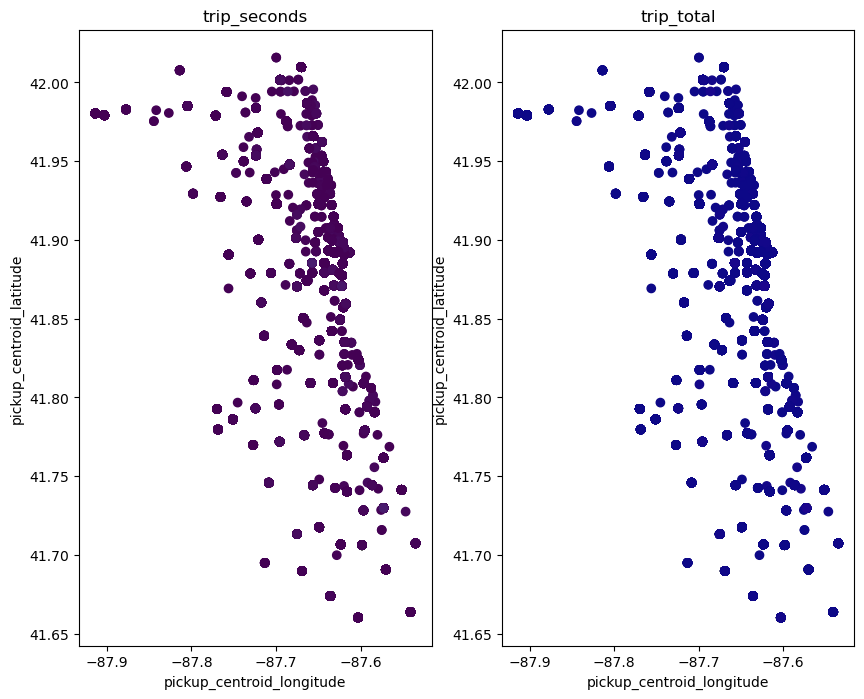

In [55]:
x = for_feature['pickup_centroid_longitude']
y = for_feature['pickup_centroid_latitude']
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x, y, c=dfpd_for_graphs['trip_miles'], cmap='viridis')
ax2.scatter(x, y, c=dfpd_for_graphs['trip_total'], cmap='plasma')
fig.set_size_inches(10, 8)
ax1.set_title('trip_seconds')
ax1.set_xlabel('pickup_centroid_longitude')
ax1.set_ylabel('pickup_centroid_latitude')
ax2.set_title('trip_total')
ax2.set_xlabel('pickup_centroid_longitude')
ax2.set_ylabel('pickup_centroid_latitude')
plt.show()

# Пока удалим колонки, которые предположительно не будут влиять на целевой показатель. Если модели не будут набирать достаточной точности, рассмотрим их возврат

In [56]:
dfsp_timed = dfsp_timed.drop('pickup_census_tract', 'pickup_centroid_location', 
                 'tips', 'tolls', 'extras', 
                 "fare", 'company', 'payment_type', 
                 'dropoff_census_tract', 'dropoff_centroid_latitude', 
                'dropoff_centroid_longitude', 'dropoff_centroid__location')
dfsp_timed.show(5)
dfsp_timed.select('pickup_community_area').distinct().count()

+--------------------+--------------------+--------------------+-------------------+------------+----------+---------------------+----------------------+----------+------------------------+-------------------------+
|             trip_id|             taxi_id|trip_start_timestamp| trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|trip_total|pickup_centroid_latitude|pickup_centroid_longitude|
+--------------------+--------------------+--------------------+-------------------+------------+----------+---------------------+----------------------+----------+------------------------+-------------------------+
|54d812a0b88f8f970...|f98ae5e71fdda8806...| 2022-01-01 00:00:00|2022-01-01 00:00:00|         536|      4.83|                   28|                    22|     14.75|            41.874005383|             -87.66351755|
|7125b9e03a0f16c2d...|8eca35a570101ad24...| 2022-01-01 00:00:00|2022-01-01 00:00:00|         897|      2.07|                    8|      

78

# Проведем агрегацию данных по часу и коммьюнити, далее в этот набор данных будем добавлять признаки

In [57]:
dfsp_timed_agg = dfsp_timed.groupby('pickup_community_area', "trip_start_timestamp").agg(
    count('trip_id').alias('trips_count'), 
    median("trip_total").alias('cost_median'), 
    median('trip_miles').alias('miles_median'),
    median("trip_seconds").alias('seconds_median'),
    median("pickup_centroid_latitude").alias('centroid_lat_median'),
    median("pickup_centroid_longitude").alias('centroid_long_median'),
    countDistinct('taxi_id').alias('taxi_countdist')
).cache()
#dfsp_timed_agg.sort('trip_start_timestamp').show(5)
#dfsp_timed_agg.printSchema()

    В итоге, наш целевой показатель - trips_count

In [58]:
rand_community = np.random.randint(77)

    Потерялись часы, где не было поездок в районе.

## Восполним утерянные часы

In [60]:
max_hour = '2023-07-31 23:00:00'#max(dfsp_timed.trip_start_timestamp) 
min_hour = '2022-01-01 00:00:00' #min(dfsp_timed.trip_start_timestamp)# 

In [61]:
hours = spark.createDataFrame([(min_hour, max_hour)], ["min_hour", "max_hour"])
hours = hours.selectExpr("explode(sequence(to_timestamp(min_hour), to_timestamp(max_hour), interval 1 hour)) as time") 

hours=hours.select(F.date_trunc('hour', hours.time).alias("hour_cons")).cache()

In [ ]:
hours.sort(hours.hour_cons.desc()).show(5)
hours.show(5)
hours.count()

In [62]:
allhours_schema = StructType([ \
                                StructField("hour_cons",TimestampType(),True), \
                                StructField("pickup_community_area",IntegerType (),True) \
                              ])
all_hours = spark.createDataFrame([], allhours_schema)
for i in range(78):
    temp = hours.withColumn('pickup_community_area', lit(i))
    all_hours = all_hours.union(temp)

In [ ]:
all_hours.show(5)
all_hours.filter('pickup_community_area==77').sort(all_hours.hour_cons.desc()).show(5)
all_hours.count()

## Закинем в ДФ со всеми районами и часами агрегированные данные

In [63]:
all_hours = all_hours \
    .join(dfsp_timed_agg, (all_hours.hour_cons == dfsp_timed_agg.trip_start_timestamp) &
    (all_hours.pickup_community_area == dfsp_timed_agg.pickup_community_area), 'left_outer').select(
    all_hours.pickup_community_area,
    all_hours.hour_cons,
    dfsp_timed_agg.taxi_countdist,
    dfsp_timed_agg.trips_count,
    dfsp_timed_agg.cost_median,
    dfsp_timed_agg.miles_median,
    dfsp_timed_agg.seconds_median,
    dfsp_timed_agg.taxi_countdist
    ).na.fill(value=0).cache()

#all_hours = all_hours.na.fill(value=0)
#all_hours.filter(all_hours.pickup_community_area==rand_community).sort(all_hours.hour_cons.desc()).show(30)
#all_hours.filter(all_hours.pickup_community_area==rand_community).count()

In [ ]:
dfsp_timed_agg.filter(dfsp_timed.pickup_community_area==rand_community).sort(dfsp_timed.trip_start_timestamp.desc()).show(30)

In [64]:
mem_use()

Количество используемой памяти 48_973_572 байт, пиковое 76_008_173 байт


In [ ]:
all_hours.explain()

In [ ]:
all_hours.toPandas().to_csv('all_hours.csv')
#all_hours.repartition(1).write.mode('overwrite').csv("all_hours")

# Итог первого этапа:
    составили сгруппированные данные по району и времени. 
    Восстановили полную временную шкалу.
    Выделили целевой признак trips_count
    промежуточный датасэт -  all_hours